### Problem 1

In [2]:
%env DDE_BACKEND=pytorch

env: DDE_BACKEND=pytorch


Using backend: pytorch



Compiling model...
'compile' took 0.000219 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [3.73e-02, 3.68e-02, 1.00e+00, 1.00e+00]    [3.48e-02, 3.74e-02, 1.00e+00, 1.00e+00]    [9.90e-01]    
1000      [1.03e-02, 1.03e-01, 3.17e-02, 4.57e-02]    [9.42e-03, 8.27e-02, 3.17e-02, 4.57e-02]    [2.53e-01]    
2000      [3.10e-04, 1.34e-02, 7.99e-04, 1.63e-03]    [3.27e-04, 1.17e-02, 7.99e-04, 1.63e-03]    [4.45e-02]    
3000      [1.75e-04, 7.40e-03, 1.42e-04, 8.64e-05]    [1.83e-04, 7.53e-03, 1.42e-04, 8.64e-05]    [2.46e-02]    
4000      [2.49e-05, 1.79e-03, 2.96e-05, 4.70e-05]    [2.38e-05, 1.30e-03, 2.96e-05, 4.70e-05]    [8.84e-03]    
5000      [8.19e-06, 6.57e-04, 6.09e-06, 1.05e-05]    [6.78e-06, 4.94e-04, 6.09e-06, 1.05e-05]    [3.60e-03]    
6000      [6.18e-06, 4.82e-04, 3.40e-06, 1.57e-05]    [4.86e-06, 3.95e-04, 3.40e-06, 1.57e-05]    [2.20e-03]    
7000      [7.66e-06, 4.99e-04, 

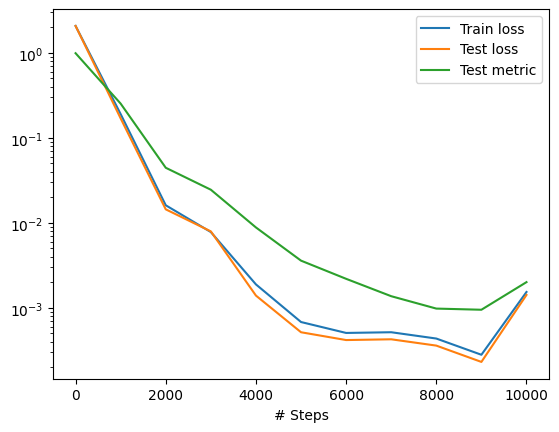

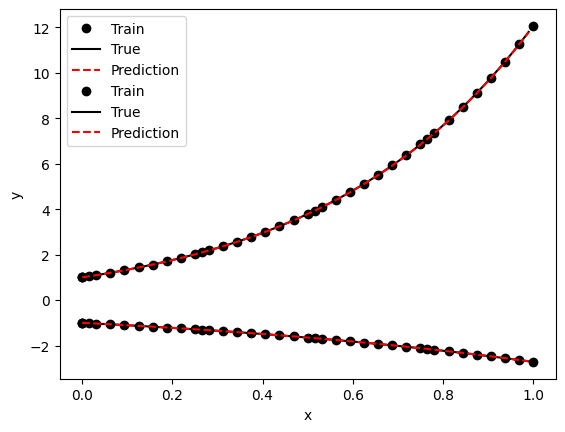

In [3]:
import deepxde as dde
import numpy as np


def ode_system(t, info):

    """ODE system.
    dx/dt = x
    dy/dt = -x+2y
    """
    x,y = info[:, 0:1], info[:, 1:]
    
    dx_t = dde.grad.jacobian(info,t,i=0)
    dy_t = dde.grad.jacobian(info,t,i=1)

    return [dx_t - x,
            dy_t -2*y + x]


def boundary(_, on_initial):
    return on_initial


def func(t):

    """
    RESULTS
    x(t)  = -e^t
    y(t) = -e^t + 2*e^(2t)

    """
    return np.hstack((-1*np.exp(t), -1*np.exp(t)+2*np.exp(2*t)))

# 0 <= t <= 1
geom = dde.geometry.TimeDomain(0, 1)
# x(0) = -1
ic1 = dde.icbc.IC(geom, lambda x: -1, boundary, component=0)
# y(0) = 1
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### Problem 2

Compiling model...
'compile' took 0.000224 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.56e-04, 1.00e+00, 4.40e+00]    [2.68e-04, 1.00e+00, 4.40e+00]    [1.04e+00]    
1000      [2.39e-05, 5.29e-11, 2.23e-09]    [1.74e-05, 5.29e-11, 2.23e-09]    [1.53e-04]    
2000      [1.69e-05, 9.39e-10, 2.46e-09]    [1.29e-05, 9.39e-10, 2.46e-09]    [1.36e-04]    
3000      [1.01e-05, 5.18e-10, 1.10e-09]    [7.76e-06, 5.18e-10, 1.10e-09]    [1.05e-04]    
4000      [4.27e-06, 7.04e-07, 7.40e-06]    [3.54e-06, 7.04e-07, 7.40e-06]    [1.29e-03]    
5000      [8.26e-07, 3.97e-08, 3.17e-07]    [5.82e-07, 3.97e-08, 3.17e-07]    [2.41e-04]    
6000      [3.85e-07, 2.30e-09, 2.74e-08]    [2.77e-07, 2.30e-09, 2.74e-08]    [8.99e-05]    
7000      [1.87e-07, 5.68e-12, 2.51e-11]    [1.33e-07, 5.68e-12, 2.51e-11]    [9.73e-06]    
8000      [2.32e-06, 1.23e-05, 1.03e-04]    [1.88e-06, 1.23e-05, 1.03e-04]    [4.68e-03]    
9000 

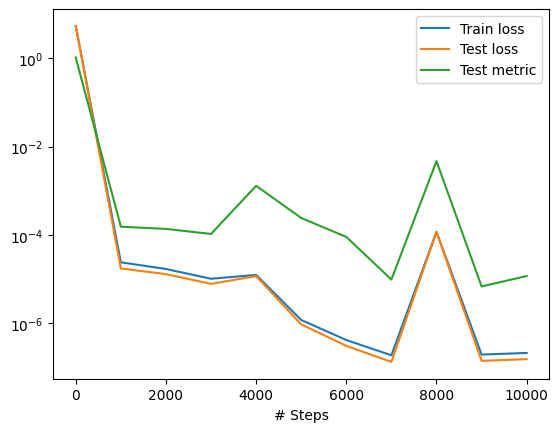

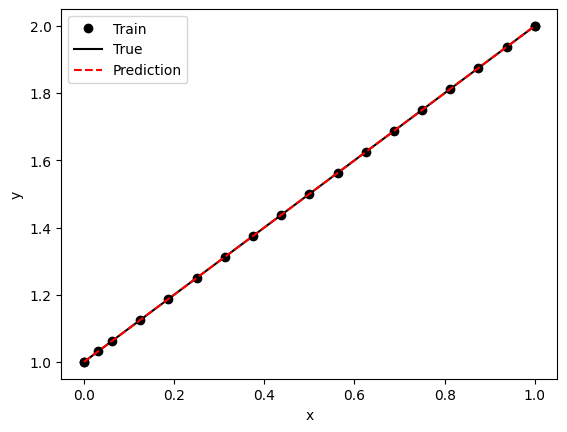

In [4]:
import deepxde as dde
import numpy as np


def pde(x, u):
    du_xx = dde.grad.hessian(u, x)
    return du_xx


def boundary_l(x, on_boundary):
    return on_boundary and x[0] == 0


def boundary_r(x, on_boundary):
    return on_boundary and x[0] == 1



def func(x):
    return x+1


geom = dde.geometry.Interval(0, 1)
bc_l = dde.icbc.DirichletBC(geom, func, boundary_l)
bc_r = dde.icbc.DirichletBC(geom, func, boundary_r)
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [1]

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)